# Analysis of historical weather in Ireland

## Author: Joanna Mnich

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import linregress
import numpy as np
from datetime import datetime, timedelta


## Clean and read data

*Pandas was used to load, clean, filter, and save station data.*


In [162]:
def clean_station(file_path, output_path):
    # Clean a Met Éireann station CSV and save year, month, wdsp (mean wind speed).
    # Args: file_path (str): path to raw CSV
        # output_path (str): path to save cleaned CSV
    
# Detect first row with actual numeric data (starts with a year)
    data_row = None
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            # skip empty lines, look for line starting with a digit (year)
            if line.strip() and line.strip()[0].isdigit():
                data_row = i
                break

    if data_row is None:
        print(f"No data found in {file_path}")
        return

# Read CSV from detected data row
    df = pd.read_csv(
        file_path,
        skiprows=data_row,
        header=None,
        na_values=["---", "NaN"],
        on_bad_lines="skip"
    )

# Assign proper column names (based on Met Éireann standard)
    col_names = [
        "year","month","meant","maxtp","mintp","mnmax",
        "mnmin","rain","gmin","wdsp","maxgt","sun"
    ][:df.shape[1]]  # adjust if file has fewer columns
    df.columns = col_names
    
# Keep only relevant columns
    df = df[["year", "month", "wdsp"]]

# Convert to numeric (coerce errors)
    for col in ["year", "month", "wdsp"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter years 2005–2025 and remove missing wdsp
    df = df.dropna(subset=["wdsp"])
    df = df[(df["year"] >= 2005) & (df["year"] <= 2025)]

# Save cleaned CSV
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} — rows: {len(df)}")


*Pandas was used inside the `clean_station` function to load, clean, filter, and save the station data files for each station.*


In [163]:
stations = {
    "Malin_Head": "Malin_Head.csv",
    "Roches_Point": "Roches_point.csv",
    "Sherkin_Island": "SherkinIsland.csv",
    "Valentia_Observatory": "Valentia_Observatory.csv",
    "Dublin_Airport": "Dublin_Airport.csv",
    "Mt_Dillon": "Mt_Dillon.csv",
    "Casement_Aerodrome": "Casement_Aerodrome.csv",
    "Belmullet": "Belmullet.csv",
    "Mullingar": "Mullingar.csv",
    "Claremorris": "Claremorris.csv"
}

for station, filename in stations.items():
    clean_station(
        file_path=f"data/raw/{filename}",
        output_path=f"data/processed/{station}_cleaned.csv"
    )


Saved data/processed/Malin_Head_cleaned.csv — rows: 250
Saved data/processed/Roches_Point_cleaned.csv — rows: 249
Saved data/processed/Sherkin_Island_cleaned.csv — rows: 249
Saved data/processed/Valentia_Observatory_cleaned.csv — rows: 249
Saved data/processed/Dublin_Airport_cleaned.csv — rows: 251
Saved data/processed/Mt_Dillon_cleaned.csv — rows: 247
Saved data/processed/Casement_Aerodrome_cleaned.csv — rows: 251
Saved data/processed/Belmullet_cleaned.csv — rows: 246
Saved data/processed/Mullingar_cleaned.csv — rows: 251
Saved data/processed/Claremorris_cleaned.csv — rows: 243


## Analyse mean wind speed from merged station script

*Pandas was used to load the merged station data, filter out unwanted rows, and calculate the mean wind speed for each station.*

pd.read_csv - read data

filtration - groupby().mean().sort_values()


In [164]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Safety check (remove any accidental master rows)
df = df[df["station"] != "ALL_STATIONS"]

df.head()

mean_wind_station = (
    df.groupby("station")["wdsp"]
      .mean()
      .sort_values(ascending=False)
)

mean_wind_station


station
Malin_Head              14.628400
Sherkin_Island          12.345783
Roches_Point            12.118072
Belmullet               11.711382
Dublin_Airport          10.206375
Casement_Aerodrome       9.704382
Valentia_Observatory     9.306426
Claremorris              7.949383
Mt_Dillon                7.008097
Mullingar                6.158566
Name: wdsp, dtype: float64

*Pandas was used to calculate summary statistics (mean, min, max, standard deviation) of wind speed for each station and to sort the results.*

.groupby().agg() → statistical aggregations (mean, min, max, std)

.sort_values() → sorting the results

In [165]:
# Wind speed range statistics by station
wind_range_station = df.groupby("station")["wdsp"].agg(["mean", "min", "max", "std"])
wind_range_station.sort_values("mean", ascending=False)


,mean,min,max,std
station,,,,
Malin_Head,14.628400,7.8,22.3,2.896937
Sherkin_Island,12.345783,7.8,21.5,2.568464
Roches_Point,12.118072,8.0,19.2,2.062148
Belmullet,11.711382,6.4,18.9,2.224766
Dublin_Airport,10.206375,6.5,16.3,1.892923
Casement_Aerodrome,9.704382,5.7,16.3,2.093481
Valentia_Observatory,9.306426,5.3,17.2,2.029391
Claremorris,7.949383,4.8,12.1,1.192933
Mt_Dillon,7.008097,3.9,12.0,1.333624


## Monthly average wind speed plot for each station

*Pandas was used to load each station's cleaned data and calculate monthly average wind speeds.  
Matplotlib was used to create line plots for each station showing average monthly wind speed from 2005 to 2025, which were saved as PNG files.*

Pandas – to read a file CSV (pd.read_csv) and calculate average monthly mean (groupby("month").mean())

Matplotlib – to create plots  plt.figure(), plt.plot(), plt.title(), plt.savefig()

In [166]:
# Plot monthly average wind speed per station
for station in stations.keys():
    df = pd.read_csv(f"data/processed/{station}_cleaned.csv")
    monthly_avg = df.groupby("month")["wdsp"].mean()

    plt.figure()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
    plt.title(f"Average Monthly Wind Speed at {station.replace('_', ' ')} (2005-2025)")
    plt.xlabel("Month")
    plt.ylabel("Average Wind Speed (wdsp)")
    plt.xticks(range(1, 13))
    plt.grid()
    plt.savefig(f"data/plots/{station}_monthly_wind_speed.png")
    plt.close()

## Annual wind speed trends 2005-2025

*Pandas was used to load the merged cleaned dataset, remove any master rows, and calculate annual mean wind speeds for each station.*

pd.read_csv - read the data

filtration (df[df["station"] != "ALL_STATIONS"]) - remove any master/aggregated rows

yearly aggregation (groupby(["station", "year"])["wdsp"].mean()) - calculate the annual mean wind speeds

reset_index() - convert the grouped result so that station and year become regular columns in the DataFrame

In [167]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Remove any accidental master rows
df = df[df["station"] != "ALL_STATIONS"]

# Compute annual mean wind speed per station
annual_trend = df.groupby(["station", "year"])["wdsp"].mean().reset_index()
annual_trend.head(100)

,station,year,wdsp
0,Belmullet,2005,11.533333
1,Belmullet,2006,11.608333
2,Belmullet,2007,11.200000
3,Belmullet,2008,11.958333
4,Belmullet,2009,11.766667
...,...,...,...
95,Malin_Head,2016,14.341667
96,Malin_Head,2017,15.100000
97,Malin_Head,2018,14.841667
98,Malin_Head,2019,14.641667


*Pandas was used to filter the annual mean wind speed data for each station.  
SciPy's `linregress` function was applied to calculate linear regression slopes, intercepts, and statistical parameters for each station's time series.  
Matplotlib was used to visualize annual wind speed trends, plotting each station's yearly values with the corresponding regression slope.*

Matplotlib – used to create plots (plt.figure(), plt.plot(), plt.xlabel(), plt.ylabel(), plt.title(), plt.legend(), plt.grid(), plt.show())

SciPy (linregress) – used to perform linear regression (slope, intercept, r_value, p_value, std_err) for each station

Pandas – used to filter data by station (annual_trend[annual_trend["station"] == station])

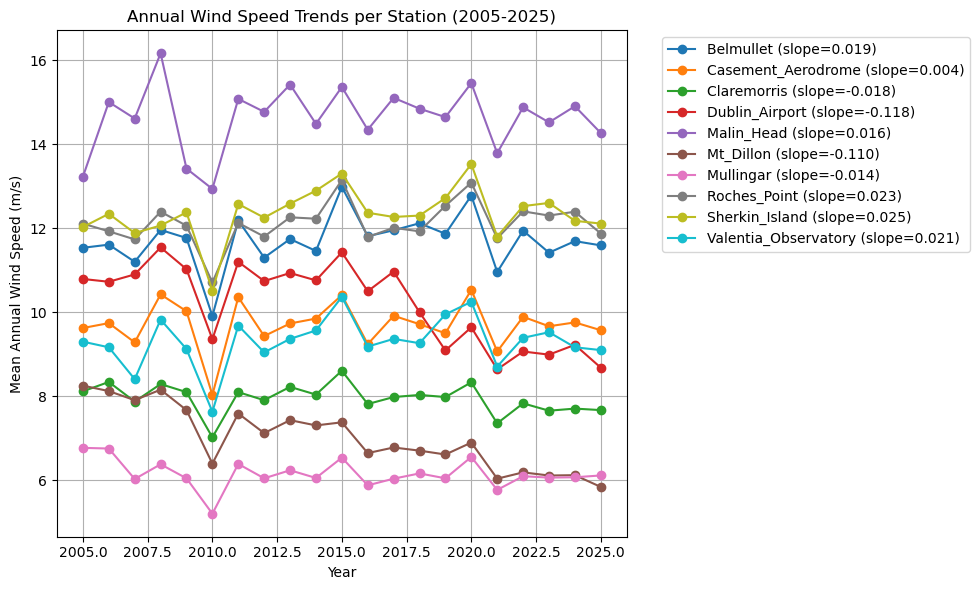

Annual wind speed slopes (m/s per year):
Belmullet: 0.019
Casement_Aerodrome: 0.004
Claremorris: -0.018
Dublin_Airport: -0.118
Malin_Head: 0.016
Mt_Dillon: -0.110
Mullingar: -0.014
Roches_Point: 0.023
Sherkin_Island: 0.025
Valentia_Observatory: 0.021


In [168]:
# Plot annual wind speed trends per station with slopes
plt.figure(figsize=(10,6))
# Dictionary to store slope for each station
slopes = {}

for station in annual_trend["station"].unique():
    subset = annual_trend[annual_trend["station"] == station]
    
    # Linear regression: slope, intercept, r_value, p_value, std_err
    slope, intercept, r_value, p_value, std_err = linregress(subset["year"], subset["wdsp"])
    slopes[station] = slope
    
    # Plot annual mean wind
    plt.plot(subset["year"], subset["wdsp"], marker='o', label=f"{station} (slope={slope:.3f})")

plt.xlabel("Year")
plt.ylabel("Mean Annual Wind Speed (m/s)")
plt.title("Annual Wind Speed Trends per Station (2005-2025)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print slopes for interpretation
print("Annual wind speed slopes (m/s per year):")
for station, slope in slopes.items():
    print(f"{station}: {slope:.3f}")


## Machine Learning Approach: Linear Regression (Scikit-learn)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [170]:
annual_trend  # columns: year, wdsp

,station,year,wdsp
0,Belmullet,2005,11.533333
1,Belmullet,2006,11.608333
2,Belmullet,2007,11.200000
3,Belmullet,2008,11.958333
4,Belmullet,2009,11.766667
...,...,...,...
205,Valentia_Observatory,2021,8.708333
206,Valentia_Observatory,2022,9.391667
207,Valentia_Observatory,2023,9.525000
208,Valentia_Observatory,2024,9.166667


In this section, a machine learning model is applied to forecast wind speeds:

- **Pandas** – used to prepare the feature (`year`) and target (`wdsp`) datasets. 

(X = annual_trend[["year"]], y = annual_trend["wdsp"])

- **Scikit-learn** – used to split the data into training and test sets, train a Linear Regression model, and evaluate its performance using RMSE and R² metrics.  

(train_test_split), (LinearRegression().fit()), (mean_squared_error, r2_score)

- **NumPy** – used to calculate the square root for the Root Mean Squared Error (RMSE) evaluation metric. (np.sqrt)

This workflow allows the model to learn the relationship between year and wind speed and assess prediction accuracy on unseen data.


In [171]:
# Prepare forecast
X = annual_trend[["year"]]
y = annual_trend["wdsp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")


RMSE: 2.510, R²: -0.081


## Monthly Seasonal Wind Pattern and Variability per Station

This section analyses seasonal patterns in wind speed for each station:

- **Pandas** – used to calculate monthly mean wind speeds and standard deviations for each station (groupby(["station","month"]).mean() and .std()), merge these statistics, and filter data for individual stations (pattern[pattern["station"] == station_name]).  
- **Matplotlib** – used to visualize the seasonal pattern, plotting mean wind speeds per month and shading ±1 standard deviation to show variability.

This approach allows us to compare seasonal wind patterns and variability across stations, highlighting months with higher or lower wind activity.

In [172]:
# Compute monthly means for each station (seasonal pattern)
monthly_pattern = df.groupby(["station", "month"])["wdsp"].mean().reset_index()

# Compute standard deviation per month to see variability
monthly_std = df.groupby(["station", "month"])["wdsp"].std().reset_index()
monthly_std.rename(columns={"wdsp": "std_wdsp"}, inplace=True)

# Merge mean + std
pattern = monthly_pattern.merge(monthly_std, on=["station", "month"])
pattern.head(12)


,station,month,wdsp,std_wdsp
0,Belmullet,1,13.595238,2.344243
1,Belmullet,2,13.080952,2.571112
2,Belmullet,3,12.090476,1.524764
3,Belmullet,4,10.704762,1.028823
4,Belmullet,5,11.066667,1.892441
5,Belmullet,6,10.480952,1.322354
6,Belmullet,7,9.776190,1.232439
7,Belmullet,8,10.765000,1.497814
8,Belmullet,9,11.075000,1.917750
9,Belmullet,10,12.110000,1.841024


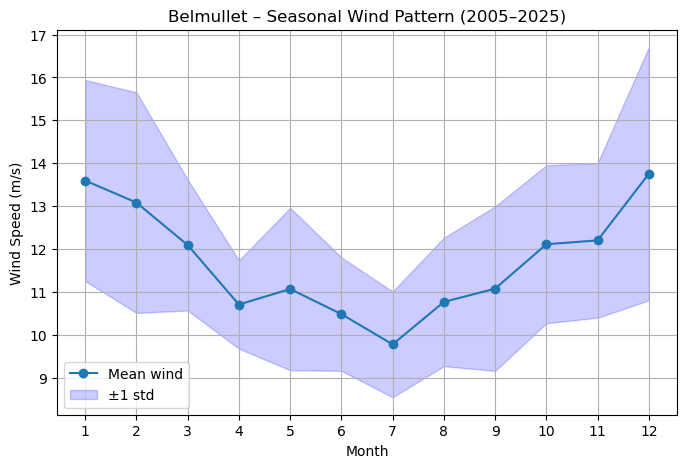

In [173]:
# Visualize seasonal pattern with variability for Belmullet
station_name = "Belmullet"
subset = pattern[pattern["station"] == station_name]

plt.figure(figsize=(8,5))
plt.plot(subset["month"], subset["wdsp"], marker='o', label="Mean wind")
plt.fill_between(subset["month"], 
                 subset["wdsp"] - subset["std_wdsp"], 
                 subset["wdsp"] + subset["std_wdsp"], 
                 color='blue', alpha=0.2, label="±1 std")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Belmullet – Seasonal Wind Pattern (2005–2025)")
plt.legend()
plt.grid(True)
plt.show()


## Power output next week (forecast)

#### Estimate next week’s wind power output for 4 stations using  P = ½ × ρ × A × V³ formula.

In this section, we forecast wind speed and estimate power output for the next 7 days for selected stations:

- **Pandas** – used to load raw station metadata, create and merge DataFrames, filter wind speed data for each station, and compile the forecast results.  
- **NumPy** – used to add random variability to the wind speed (np.random.uniform(-1,1)), and perform numeric calculations for power output (wind_speed**3).  
- **Datetime** – used to generate forecast dates for the next 7 days (datetime.today(), timedelta).  
- **Python standard library** – basic operations like loops and float/string conversions

The power output is estimated using the simplified formula \(P = 0.5 \cdot \rho \cdot A \cdot V^3\), where \(\rho\) is air density, \(A\) is rotor area, and \(V\) is wind speed. The forecast DataFrame contains predicted wind speeds and estimated power outputs for each station over the next week.


In [174]:
# Extract station metadata from raw files
files = [
    "data/raw/Dublin_Airport.csv",
    "data/raw/Malin_Head.csv",
    "data/raw/Roches_point.csv",
    "data/raw/Belmullet.csv"
]

dfs = []

for f in files:
    with open(f, "r") as file:
        lines = file.readlines()
    
    #  Station Name
    station_name = lines[0].split(":")[1].strip().title()  
    
    # Station Height (usuń 'M')
    height = float(lines[1].split(":")[1].replace("M","").strip())
    
    # Latitude,Longitude
    lat_str, lon_str = lines[2].split(",")
    latitude = float(lat_str.split(":")[1].strip())
    longitude = float(lon_str.split(":")[1].strip())
    
    # DataFrame created
    df = pd.DataFrame({
        "station": [station_name],
        "latitude": [latitude],
        "longitude": [longitude],
        "height_m": [height]
    })
    
    dfs.append(df)

# Connection all stations in one DataFrame
stations_cleaned = pd.concat(dfs, ignore_index=True)

# Save to file
stations_cleaned.to_csv("data/processed/selected_stations.csv", index=False)
print(stations_cleaned)


          station  latitude  longitude  height_m
0  Dublin Airport    53.428     -6.241      71.0
1      Malin Head    55.372     -7.339      20.0
2    Roches Point    51.793     -8.244      40.0
3       Belmullet    54.228    -10.007       9.0


In [175]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Remove any accidental master rows
df = df[df["station"] != "ALL_STATIONS"]

# Prepare forecast
stations = ["Dublin_Airport", "Malin_Head", "Roches_Point", "Belmullet"]
forecast_days = 7
today = datetime.today()

# Constants for power calculation
p = rho = 1.225  # air density in kg/m³
A = 100      # rotor swept area in m² (example)
# P = 0.5 * rho * A * V^3

forecast_list = []

for station in stations:
    subset = df[df["station"] == station]
    
    # Monthly average wind speed for current month
    current_month = today.month
    monthly_avg = subset[subset["month"] == current_month]["wdsp"].mean()
    
    for i in range(forecast_days):
        date = today + timedelta(days=i)
        # Add small random variability ±1 m/s
        wind_speed = monthly_avg + np.random.uniform(-1,1)
        
        # Estimated power output using P = 0.5 * rho * A * V^3
        power_output = 0.5 * rho * A * wind_speed**3
        
        forecast_list.append({
            "station": station,
            "date": date.date(),
            "wdsp(m/s)": round(wind_speed, 2),
            "estimated_power_W": round(power_output, 2)
        })

# Create DataFrame from forecast list
forecast_df = pd.DataFrame(forecast_list)

# Display result
print(forecast_df)



           station        date  wdsp(m/s)  estimated_power_W
0   Dublin_Airport  2026-01-08      10.90           79344.66
1   Dublin_Airport  2026-01-09      10.88           78930.38
2   Dublin_Airport  2026-01-10      12.36          115576.51
3   Dublin_Airport  2026-01-11      12.19          111082.60
4   Dublin_Airport  2026-01-12      11.93          104109.09
5   Dublin_Airport  2026-01-13      10.91           79512.93
6   Dublin_Airport  2026-01-14      10.94           80299.95
7       Malin_Head  2026-01-08      18.32          376564.85
8       Malin_Head  2026-01-09      17.27          315695.19
9       Malin_Head  2026-01-10      17.82          346534.26
10      Malin_Head  2026-01-11      16.96          299062.65
11      Malin_Head  2026-01-12      17.50          328056.03
12      Malin_Head  2026-01-13      16.72          286356.27
13      Malin_Head  2026-01-14      16.57          278727.87
14    Roches_Point  2026-01-08      13.81          161315.09
15    Roches_Point  2026

#### Visualization of Estimated Power Output

- **Matplotlib** – used to create visualizations for the 7-day forecast.  
  - The first plot shows the estimated power output over the next 7 days for all selected stations.  
  - The second, detailed plot uses dual y-axes to display both wind speed (left axis) and estimated power (right axis) for each station.  
- **Pandas** – used to filter the forecast DataFrame for individual stations to prepare data for plotting. Create forecast_df and filter data per station (forecast_df[forecast_df["station"] == station]) 
- **Datetime** – dates are handled via forecast_df['date']
These plots help to visually interpret daily variations in wind speed and the corresponding estimated power output for each station.


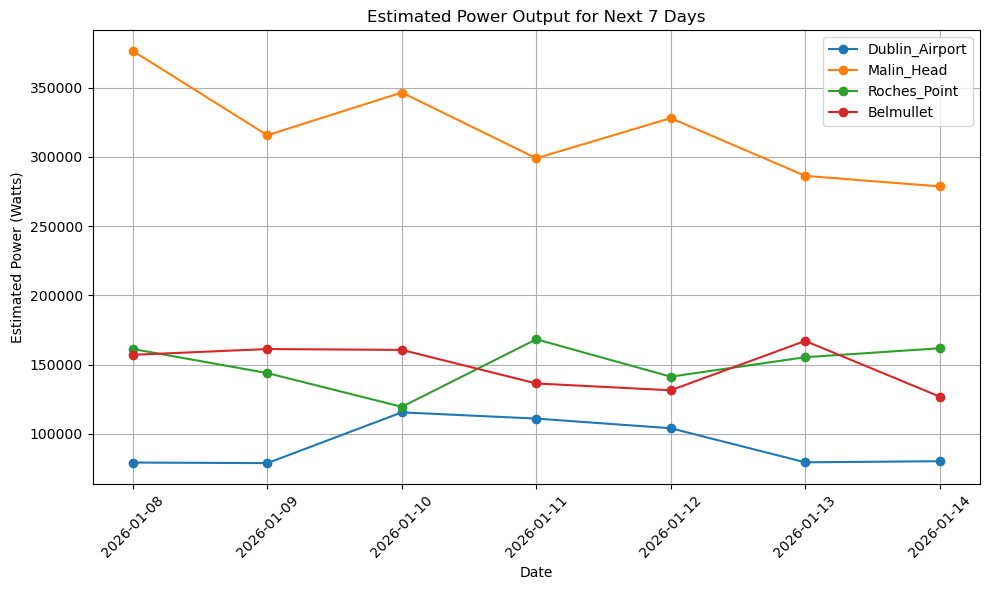

In [176]:
# Plot
plt.figure(figsize=(10,6))
for station in stations:
    subset = forecast_df[forecast_df["station"] == station]
    plt.plot(subset["date"], subset["estimated_power_W"], marker='o', label=station)

plt.title("Estimated Power Output for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Estimated Power (Watts)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

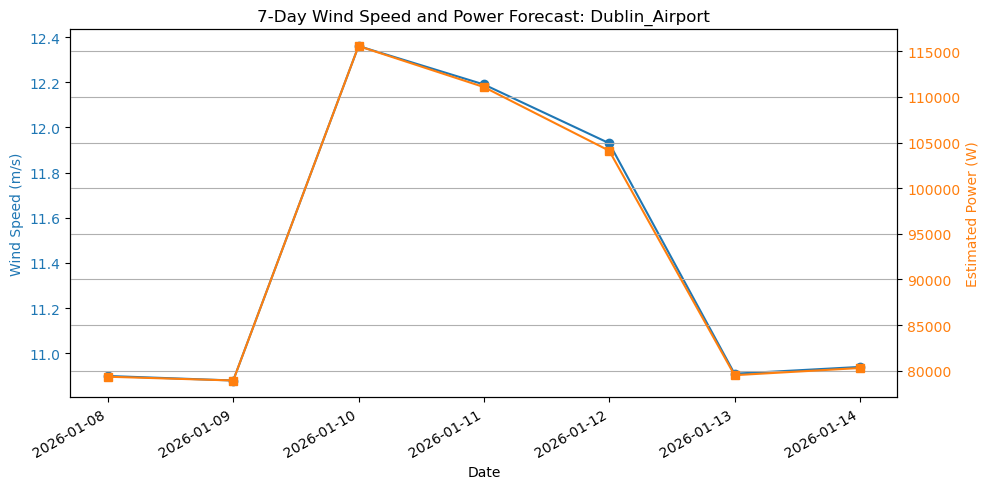

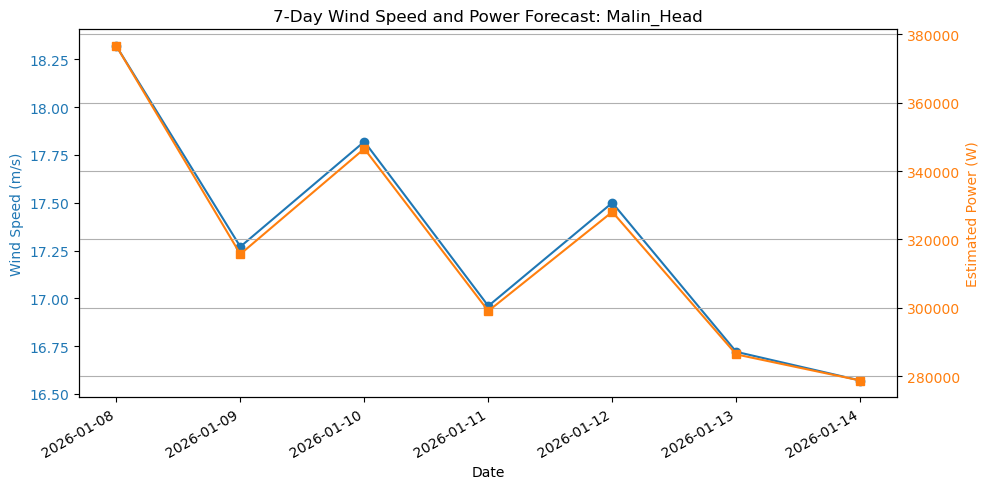

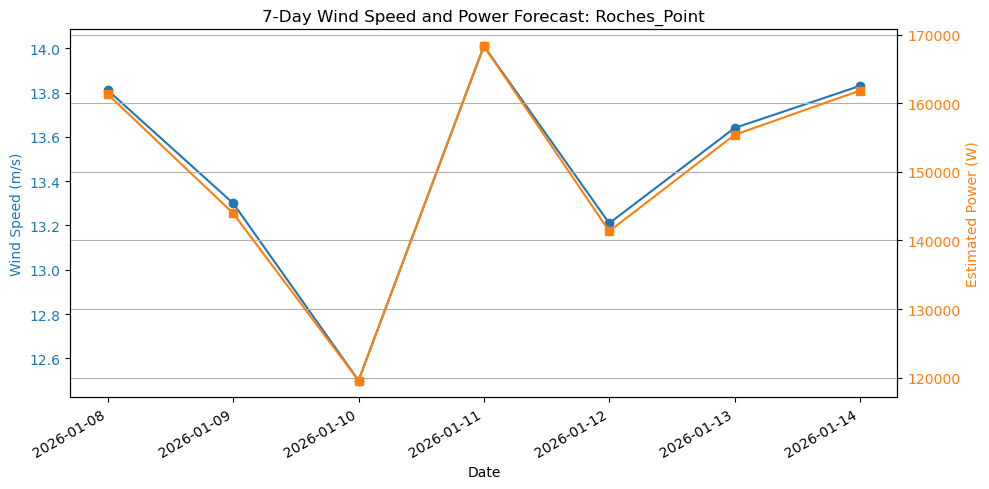

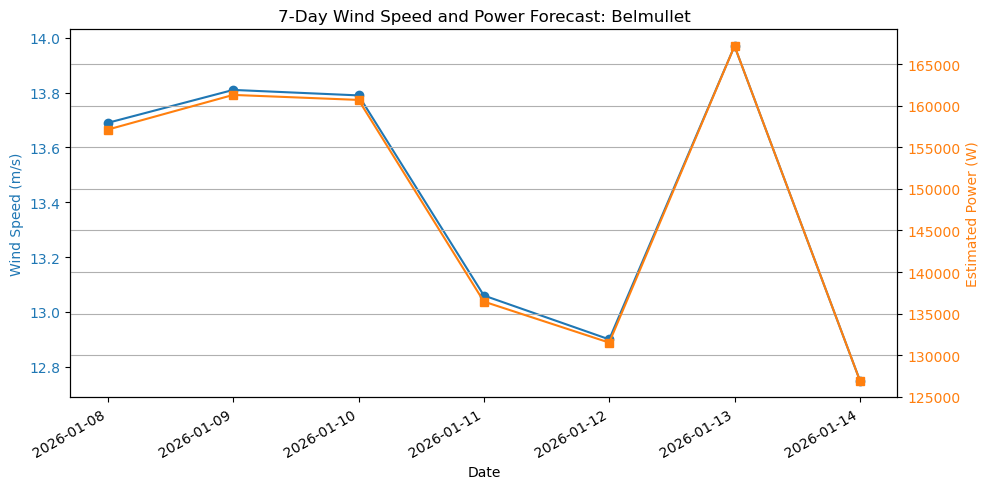

In [177]:
# Detailed plot with wind speed and power
stations = forecast_df['station'].unique()

for station in stations:
    subset = forecast_df[forecast_df['station'] == station]

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Wind speed axis (LEFT)
    ax1.plot(
        subset['date'],
        subset['wdsp(m/s)'],
        marker='o',
        color='tab:blue',
        label='Wind Speed (m/s)'
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Wind Speed (m/s)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Power axis (RIGHT)
    ax2 = ax1.twinx()
    ax2.plot(
        subset['date'],
        subset['estimated_power_W'],
        marker='s',
        color='tab:orange',
        label='Estimated Power (W)'
    )
    ax2.set_ylabel("Estimated Power (W)", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f"7-Day Wind Speed and Power Forecast: {station}")
    fig.autofmt_xdate()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Trend Analysis for a wind speeds in the next 10 years

The linear regression models are used here to forecast annual wind speeds for each station from 2026 to 2035:

- **Pandas** – used to filter historical data for each station (annual_trend[annual_trend["station"] == station]), create a DataFrame for future years, store the predicted wind speeds, and save the forecast to a CSV file (forecast_df.to_csv()).  
- **Scikit-learn (`LinearRegression`)** – used to train a separate model for each station and predict annual wind speeds for the next 10 years.  

This approach provides a station-by-station long-term wind speed forecast, which can be used for planning and estimating future power generation.


In [178]:
# Forecast configuration

FORECAST_START = 2026
FORECAST_END = 2035

forecast_years = list(range(FORECAST_START, FORECAST_END + 1))
forecast_results = []

# Annual wind speed forecast

for station in annual_trend["station"].unique():
    
    # Select data for one station
    df_station = annual_trend[annual_trend["station"] == station]
    
    # Features and target
    X = df_station[["year"]]
    y = df_station["wdsp"]
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Prepare future years DataFrame
    future_years_df = pd.DataFrame(forecast_years, columns=["year"])
    
    # Predict future wind speed
    predicted_wdsp = model.predict(future_years_df)
    
    # Store results
    for year, wind in zip(forecast_years, predicted_wdsp):
        forecast_results.append({
            "station": station,
            "year": year,
            "predicted_wind_speed": round(wind, 2)
        })

# Convert results to DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Save to file
forecast_df.to_csv(
    "forecast_wind_speed_2026_2035.csv",
    index=False
)
forecast_df.head()

,station,year,predicted_wind_speed
0,Belmullet,2026,11.91
1,Belmullet,2027,11.93
2,Belmullet,2028,11.95
3,Belmullet,2029,11.96
4,Belmullet,2030,11.98
